<a href="https://colab.research.google.com/github/kayracoskun/GNN-Anomaly/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake News / Fraud Detection**
Graph Neural Network Anomaly Detection

## Importing libraries

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 23.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 10.5

In [3]:
# control the version of torch_geometric
import torch_geometric

torch_geometric.__version__


'2.2.0'

## Dataset
- Contains news propagation graphs extracted from Twitter
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Preprocessing: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features

In [4]:
# in the default version of dataset train and test data unbalanced so we change test and train dataset
# UPFD: User Preference-aware Fake News Detection
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting ./gossipcop/raw/uc
Processing...


Train Samples:  3826
Test Samples:  1092


Done!


In [5]:
# 7 and 40 are simple example 
sample_id=39
train_data[sample_id].edge_index

tensor([[0, 0, 0, 0, 0, 3, 3],
        [1, 2, 3, 4, 5, 6, 7]])

In [ ]:
# this data consist of 3 parameter
# first parameter connected node embeddings [connected_node_number, ten_profile_features_word_embeddings] 
# second parameter edge index [root_node, connected_node]
# third paramter fake or real news data

train_data[sample_id]

Data(x=[8, 310], edge_index=[2, 7], y=[1])

- In the above example first vector defined node
- Second vector linked node to root node

## Visualize the graph neural networks

In [ ]:
"""
Had to import this "manually" due to some errors.
"""

!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


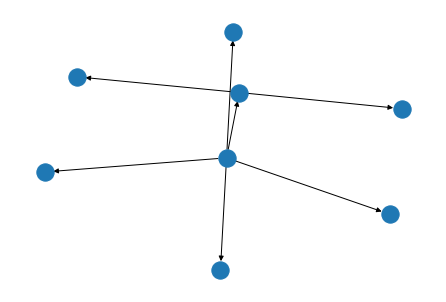

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

## Node features

In [ ]:
# Shape [x, 310] ==> 310 is embeddings for 10 profile features
# x is related to connected nodes to root node
print(train_data[sample_id].x.shape)
print(train_data[sample_id].x)

torch.Size([8, 310])
tensor([[0.4630, 0.5434, 0.5594,  ..., 0.4863, 0.1111, 0.1147],
        [0.4508, 0.5909, 0.5090,  ..., 0.1986, 0.1111, 0.1029],
        [0.4569, 0.4519, 0.6026,  ..., 0.8493, 0.1111, 0.0000],
        ...,
        [0.4323, 0.5847, 0.6395,  ..., 0.6986, 0.1111, 0.3676],
        [0.5242, 0.4985, 0.5369,  ..., 0.4863, 0.1111, 0.0000],
        [0.4630, 0.5434, 0.5594,  ..., 0.4863, 0.1111, 0.1147]])


## Class Distribution

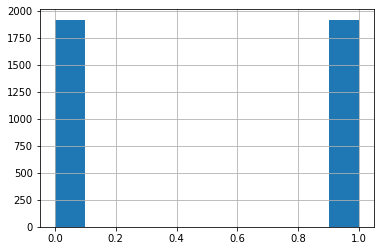

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

## Data loaders

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Create GNN Model

This is directed graph, it will only share information from the root

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        # GATConv = Graph Attention Networks -  https://arxiv.org/abs/1710.10903
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        # Applies linear transformation
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

## Training

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.70 | TestLoss: 0.68 | TestAcc: 0.51 | TestF1: 0.02
Epoch: 01 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.53 | TestF1: 0.08
Epoch: 02 |  TrainLoss: 0.68 | TestLoss: 0.66 | TestAcc: 0.50 | TestF1: 0.66
Epoch: 03 |  TrainLoss: 0.65 | TestLoss: 0.65 | TestAcc: 0.49 | TestF1: 0.66
Epoch: 04 |  TrainLoss: 0.63 | TestLoss: 0.58 | TestAcc: 0.76 | TestF1: 0.67
Epoch: 05 |  TrainLoss: 0.58 | TestLoss: 0.55 | TestAcc: 0.68 | TestF1: 0.51
Epoch: 06 |  TrainLoss: 0.53 | TestLoss: 0.49 | TestAcc: 0.76 | TestF1: 0.67
Epoch: 07 |  TrainLoss: 0.53 | TestLoss: 0.54 | TestAcc: 0.64 | TestF1: 0.73
Epoch: 08 |  TrainLoss: 0.46 | TestLoss: 0.41 | TestAcc: 0.91 | TestF1: 0.91
Epoch: 09 |  TrainLoss: 0.42 | TestLoss: 0.45 | TestAcc: 0.80 | TestF1: 0.83
Epoch: 10 |  TrainLoss: 0.41 | TestLoss: 0.39 | TestAcc: 0.86 | TestF1: 0.87
Epoch: 11 |  TrainLoss: 0.37 | TestLoss: 0.33 | TestAcc: 0.92 | TestF1: 0.91
Epoch: 12 |  TrainLoss: 0.33 | TestLoss: 0.38 | TestAcc: 0.81 | TestF1: 0.77

## Validate the accuracy

In [ ]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.132912   0.0     0
1    0.823251   1.0     1
2    0.992463   1.0     1
3    0.067484   0.0     0
4    0.108018   0.0     0
5    0.961466   1.0     1
6    0.869616   1.0     1
7    0.858568   1.0     1
8    0.186564   0.0     0
9    0.720220   1.0     1
